In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
import itertools
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib import animation
import numpy as np
import pandas as pd
from numpy import genfromtxt


from IPython.display import HTML
import seaborn as sns
from dataclasses import dataclass

In [6]:
data = pd.read_csv("../resources/TB3MS.csv", parse_dates=["DATE"])
r = genfromtxt("../treasury_bill_output_r.txt", filling_values=0, delimiter=",")
change_points = np.loadtxt("../treasury_bill_output_change_points.txt").astype(np.uint)

(0.0, 159.0)

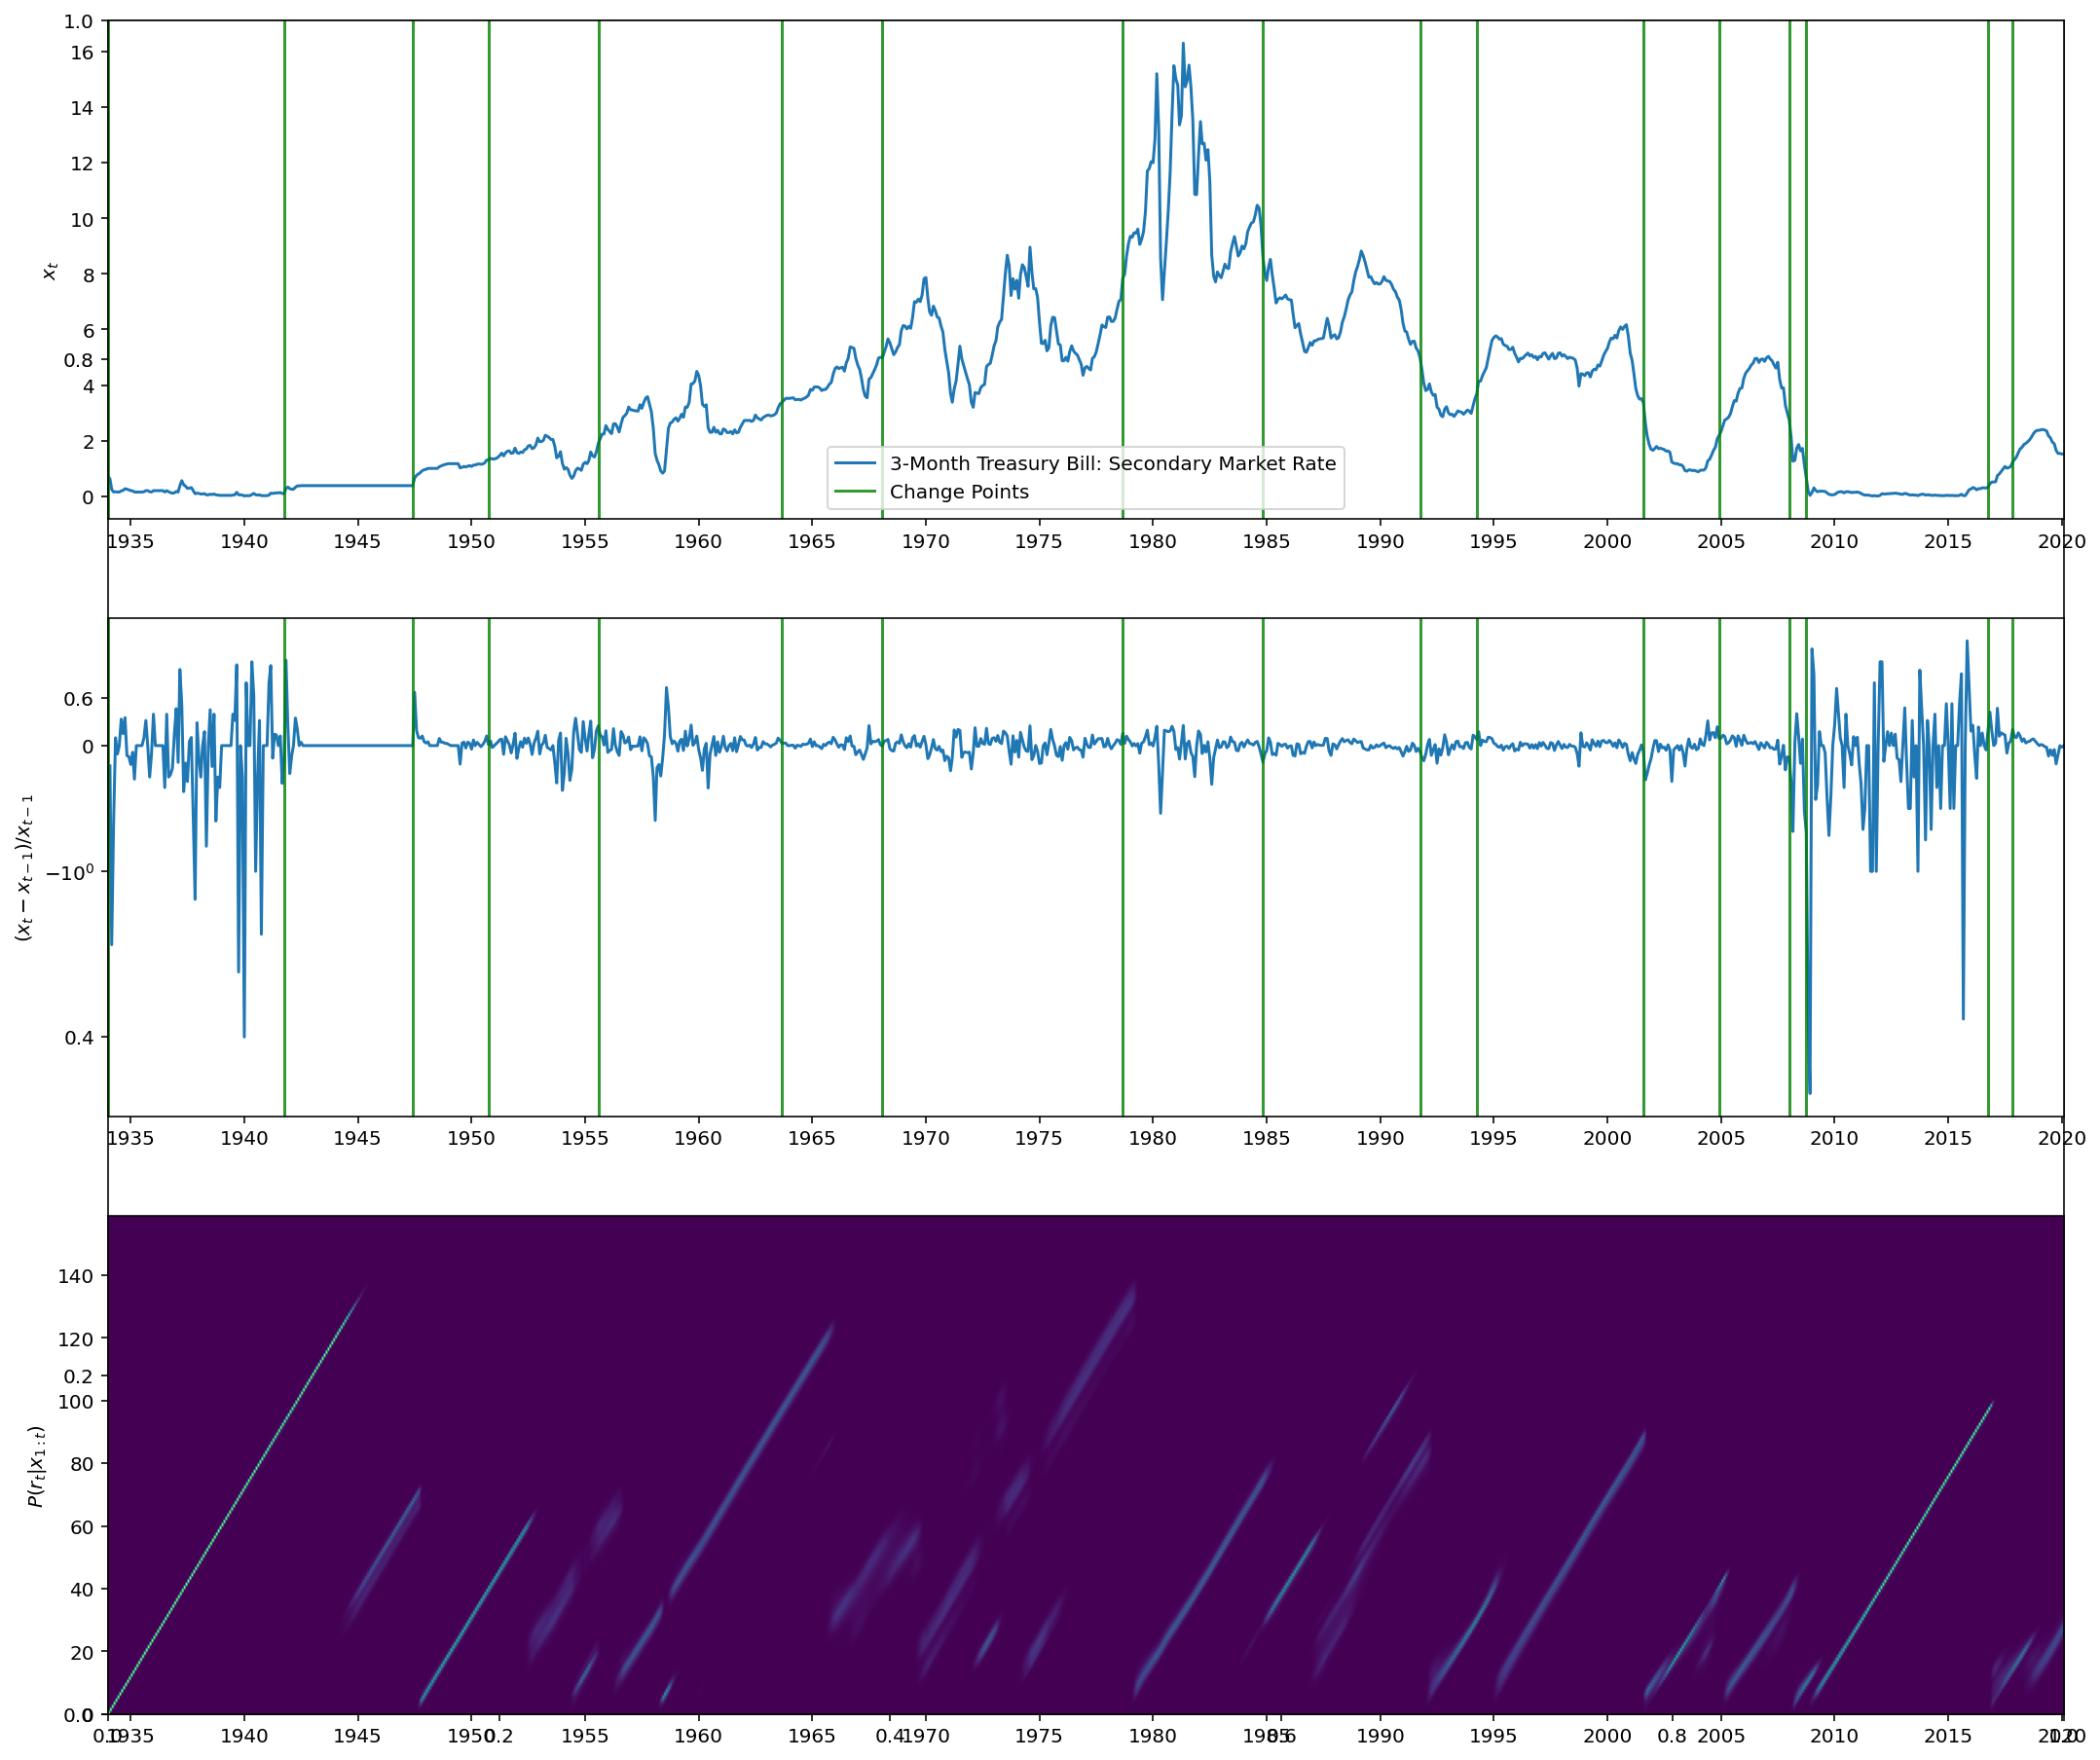

In [8]:
fig, ax = plt.subplots(figsize=[18, 16], sharex=True)

ax = fig.add_subplot(3, 1, 1)
ax.plot("DATE", "TB3MS", data=data, label="3-Month Treasury Bill: Secondary Market Rate")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

#ax.set_yscale('symlog', linthreshy=20)
ax.set_ylabel("$x_t$")
for change_point in change_points:
    line = ax.axvline(data.DATE.iloc[change_point], color="green", alpha=0.8)
line.set_label("Change Points")
ax.legend()

ax = fig.add_subplot(3, 1, 2, sharex=ax)
pct_changes = np.diff(data["TB3MS"]) /data["TB3MS"].values[1:]
ax.set_yscale("symlog")
ax.set_ylabel("$(x_t - x_{t-1}) / x_{t-1}$")
ax.plot(data["DATE"].values[1:], pct_changes, label="")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

for change_point in change_points:
    line = ax.axvline(data.DATE.iloc[change_point], color="green", alpha=0.8)

ax = fig.add_subplot(3, 1, 3, sharex=ax)
x_lims = mdates.date2num([data.DATE.min(), data.DATE.max()])
#rp = np.rot90(r, 1)
#rp[np.isinf(rp)] = np.min(rp[np.isfinite(rp)])

ax.imshow(
    np.transpose(r),
    cmap=cm.viridis,
    extent = [x_lims[0], x_lims[1], 0, r.shape[1]],
    aspect="auto",
    origin="lower",
)
ax.set_ylabel("$P(r_t|x_{1:t})$")
ax.set_ylim(0, max_length)